In [1]:
import clip
import torch.nn as nn
from torchvision import datasets
import argparse
import torch
import pandas as pd
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)
model.load_state_dict(torch.load("/home/tsuneda/copy/CLIP_finetuning/models/finetuned_clip_model_5_128.pth"))

<All keys matched successfully>

In [36]:
# modelのtext encoderのパラメータを固定
for param in model.transformer.parameters():
    param.requires_grad = False
    

In [3]:
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7feb8fa983a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [5]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

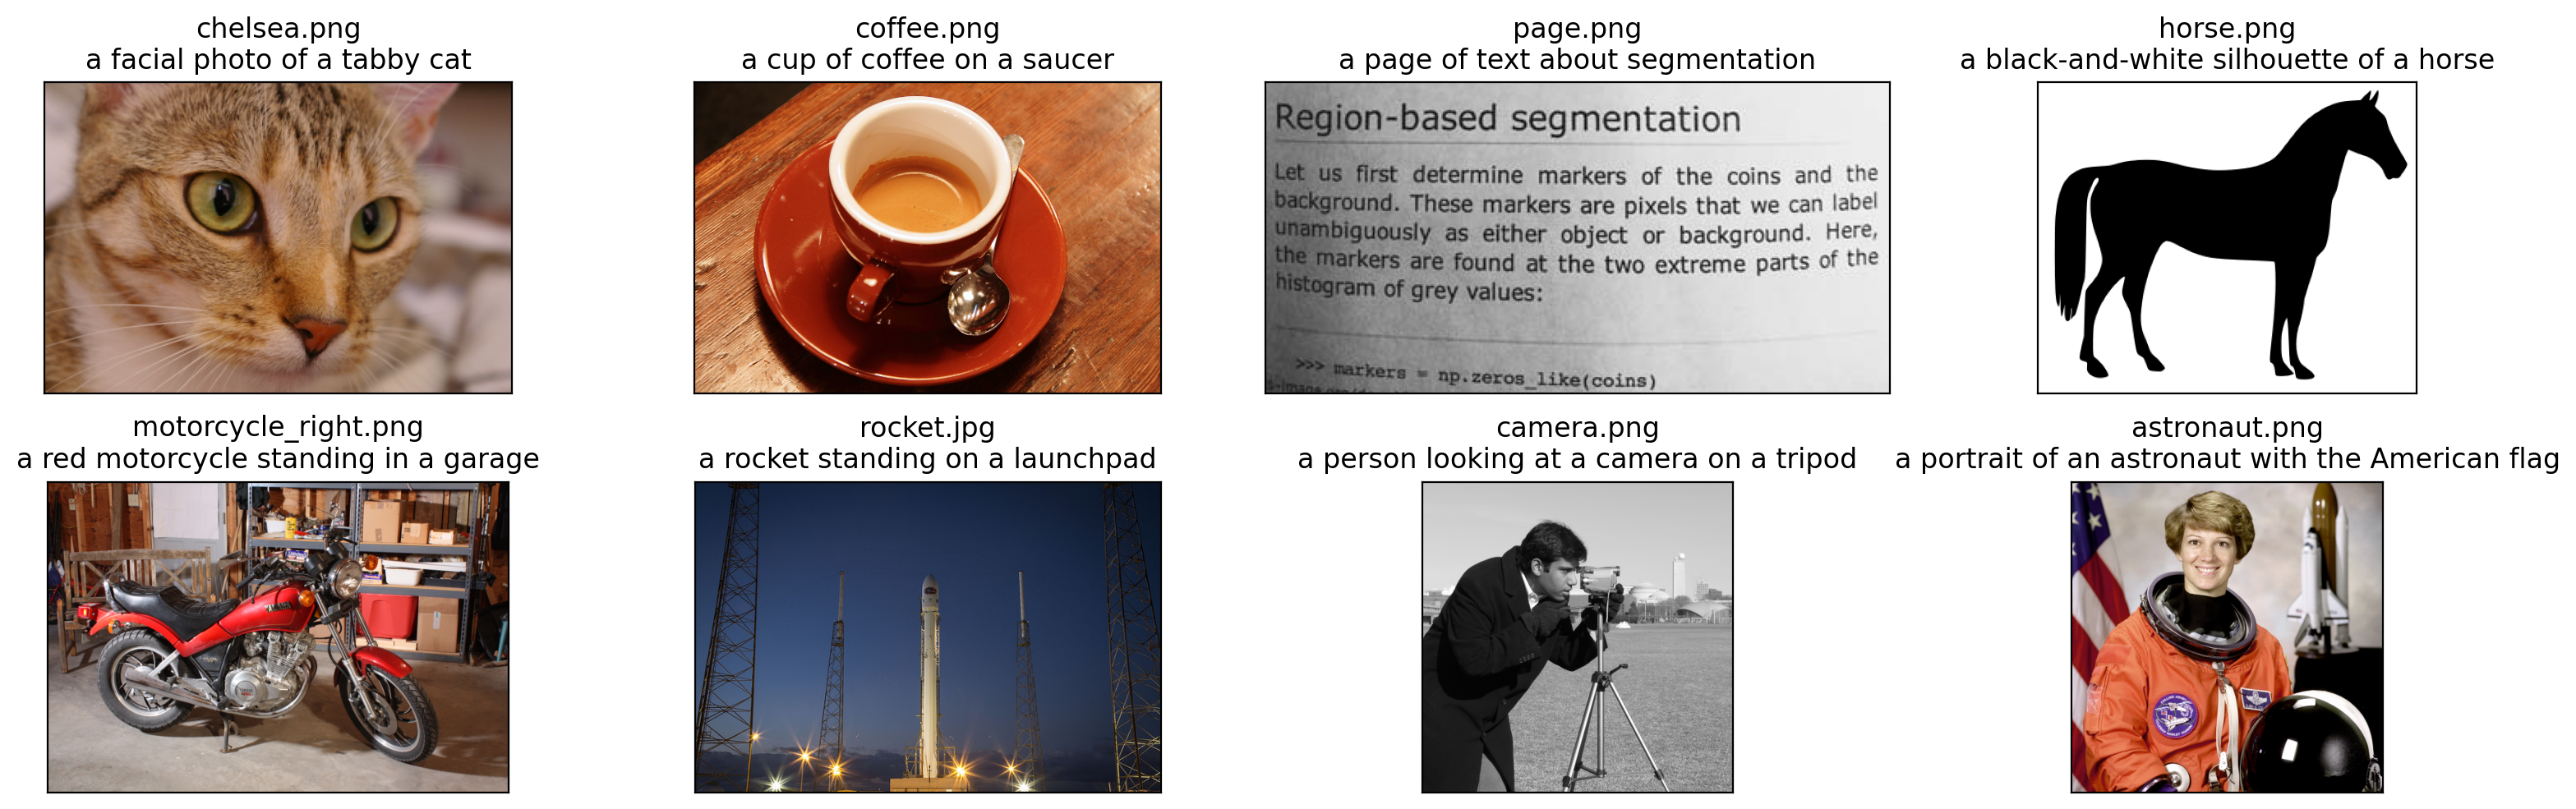

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [21]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [22]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [23]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [24]:
print(similarity)

[[0.9971089  0.99548084 0.9979128  0.99907863 0.9989879  0.9983109
  0.99906904 0.99857223]
 [0.9967889  0.99545646 0.99806726 0.999132   0.9990722  0.9984816
  0.9991461  0.9986151 ]
 [0.99674726 0.99545366 0.99809974 0.99911857 0.9990976  0.99849236
  0.9991437  0.9986467 ]
 [0.996651   0.99527633 0.99803436 0.9991063  0.99902004 0.9984559
  0.9991604  0.9985472 ]
 [0.9967984  0.9954989  0.99809563 0.9991465  0.99915516 0.9984783
  0.9991764  0.9986527 ]
 [0.996717   0.9953753  0.99805415 0.9991001  0.9990649  0.9985273
  0.99912333 0.9985998 ]
 [0.9967204  0.9953732  0.9980624  0.99910843 0.9990643  0.99848163
  0.999138   0.99857736]
 [0.9966797  0.99536294 0.9978754  0.9989308  0.9989341  0.9984478
  0.9989404  0.99882615]]


In [25]:
print(image_input.shape)
print(text_tokens.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 77])


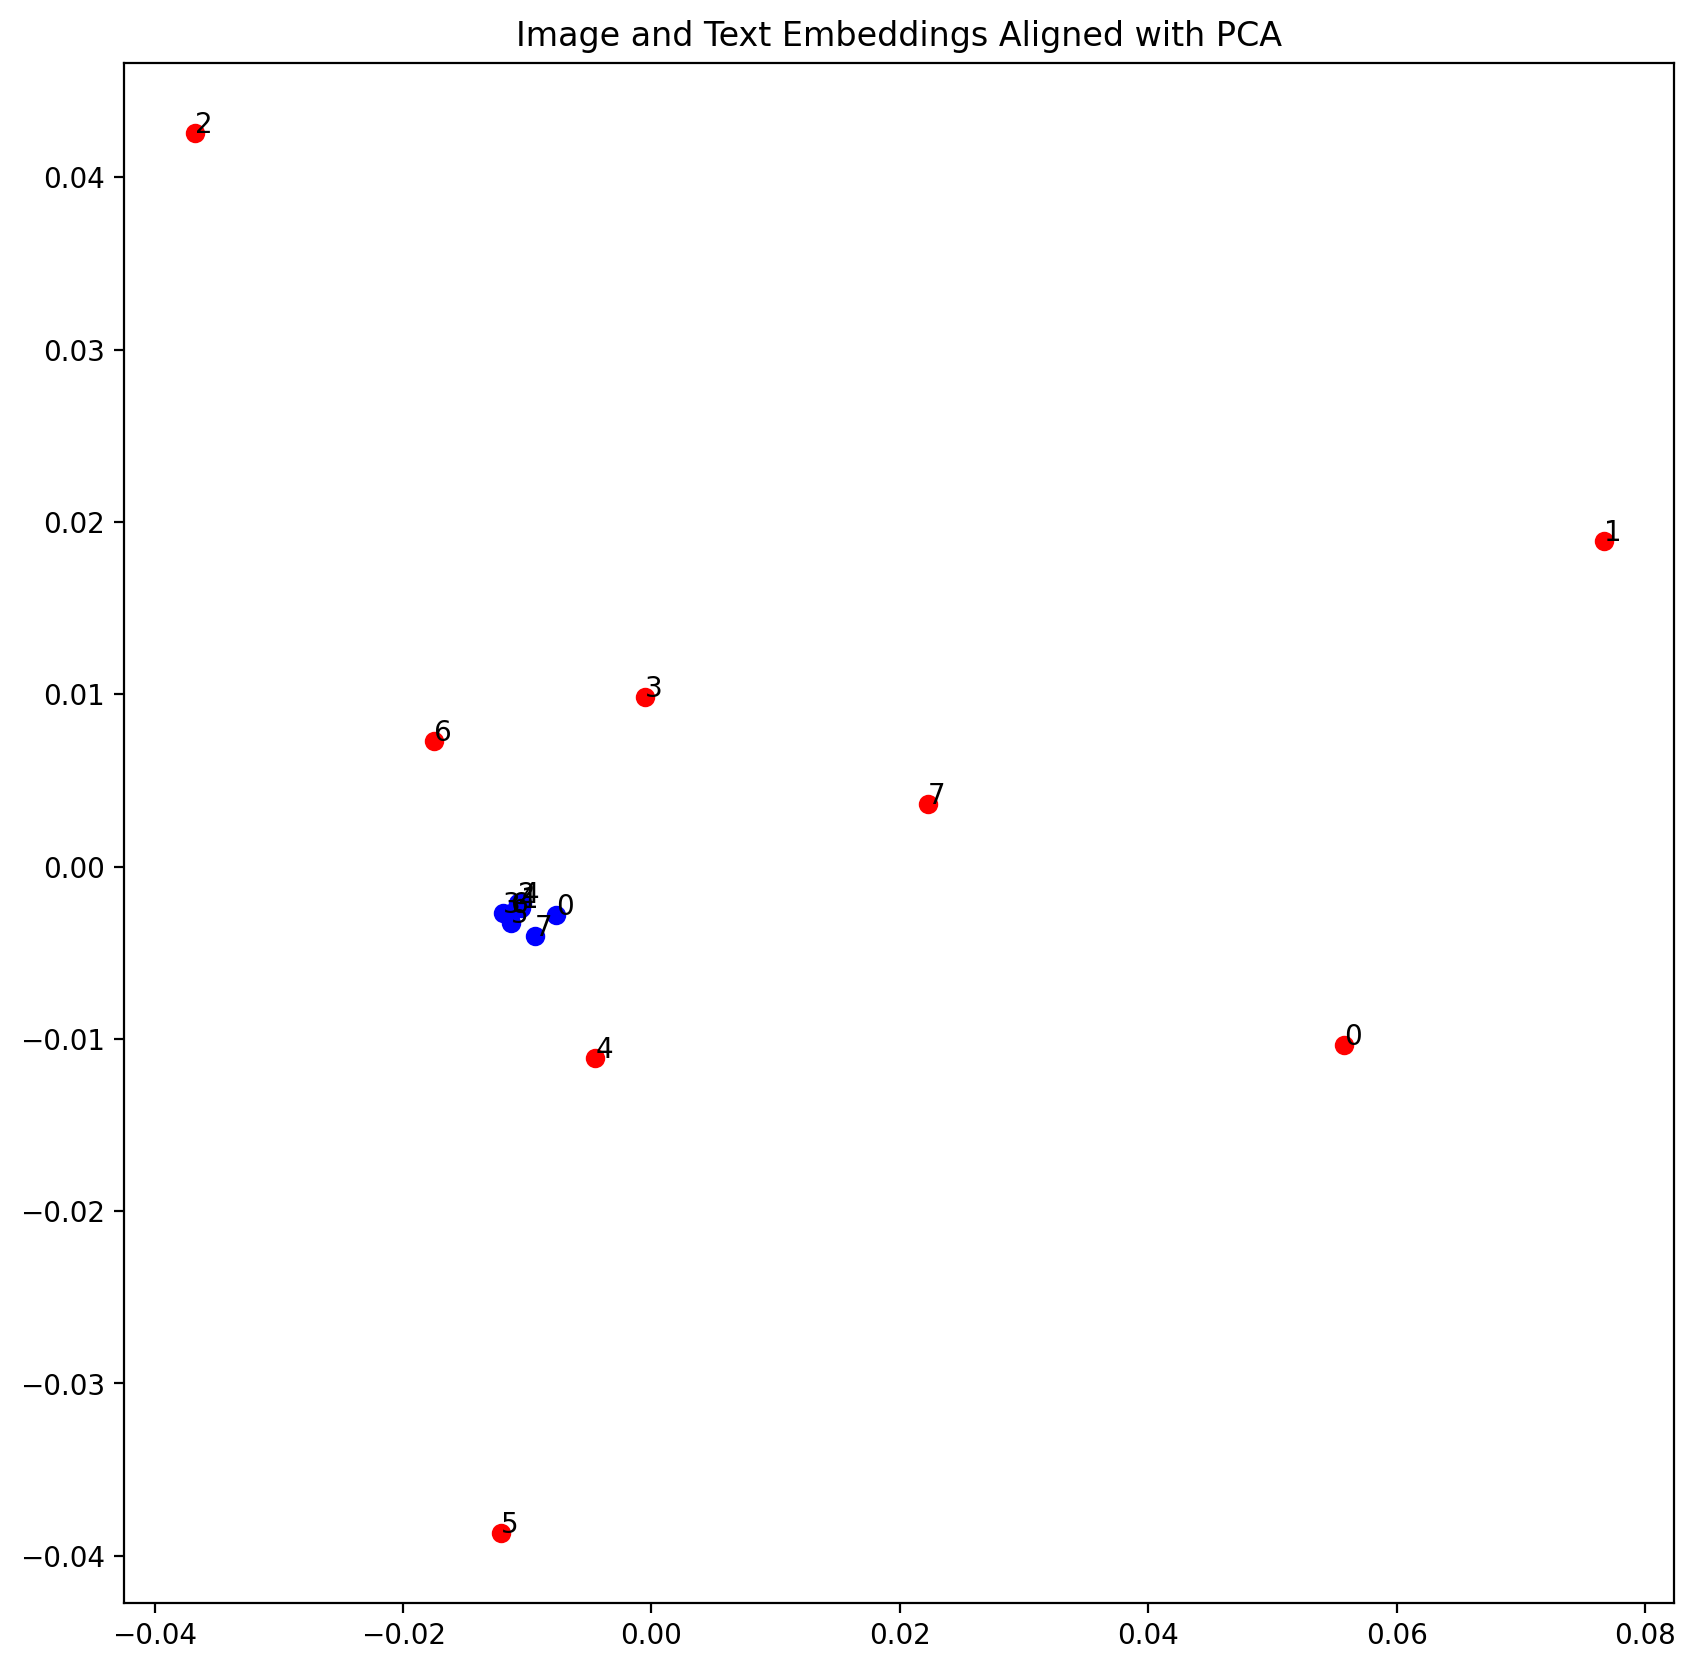

In [27]:
# image_featuresとtext_featuresを用いた埋め込み空間の可視化
# ペアの画像とテキストの埋め込みを同じ色でプロットする

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vis_data = pca.fit_transform(np.concatenate([image_features.cpu().numpy(), text_features.cpu().numpy()]))
image_vis_data = vis_data[:len(image_features)]
text_vis_data = vis_data[len(image_features):]

plt.figure(figsize=(10, 10))
plt.title("Image and Text Embeddings Aligned with PCA")
plt.scatter(image_vis_data[:, 0], image_vis_data[:, 1], c="r")
plt.scatter(text_vis_data[:, 0], text_vis_data[:, 1], c="b")
for i, (x, y) in enumerate(image_vis_data):
    plt.annotate(i, (x, y))

for i, (x, y) in enumerate(text_vis_data):
    plt.annotate(i, (x, y))

plt.show()




Text(0.5, 1.0, 'Cosine similarity between text and image features')

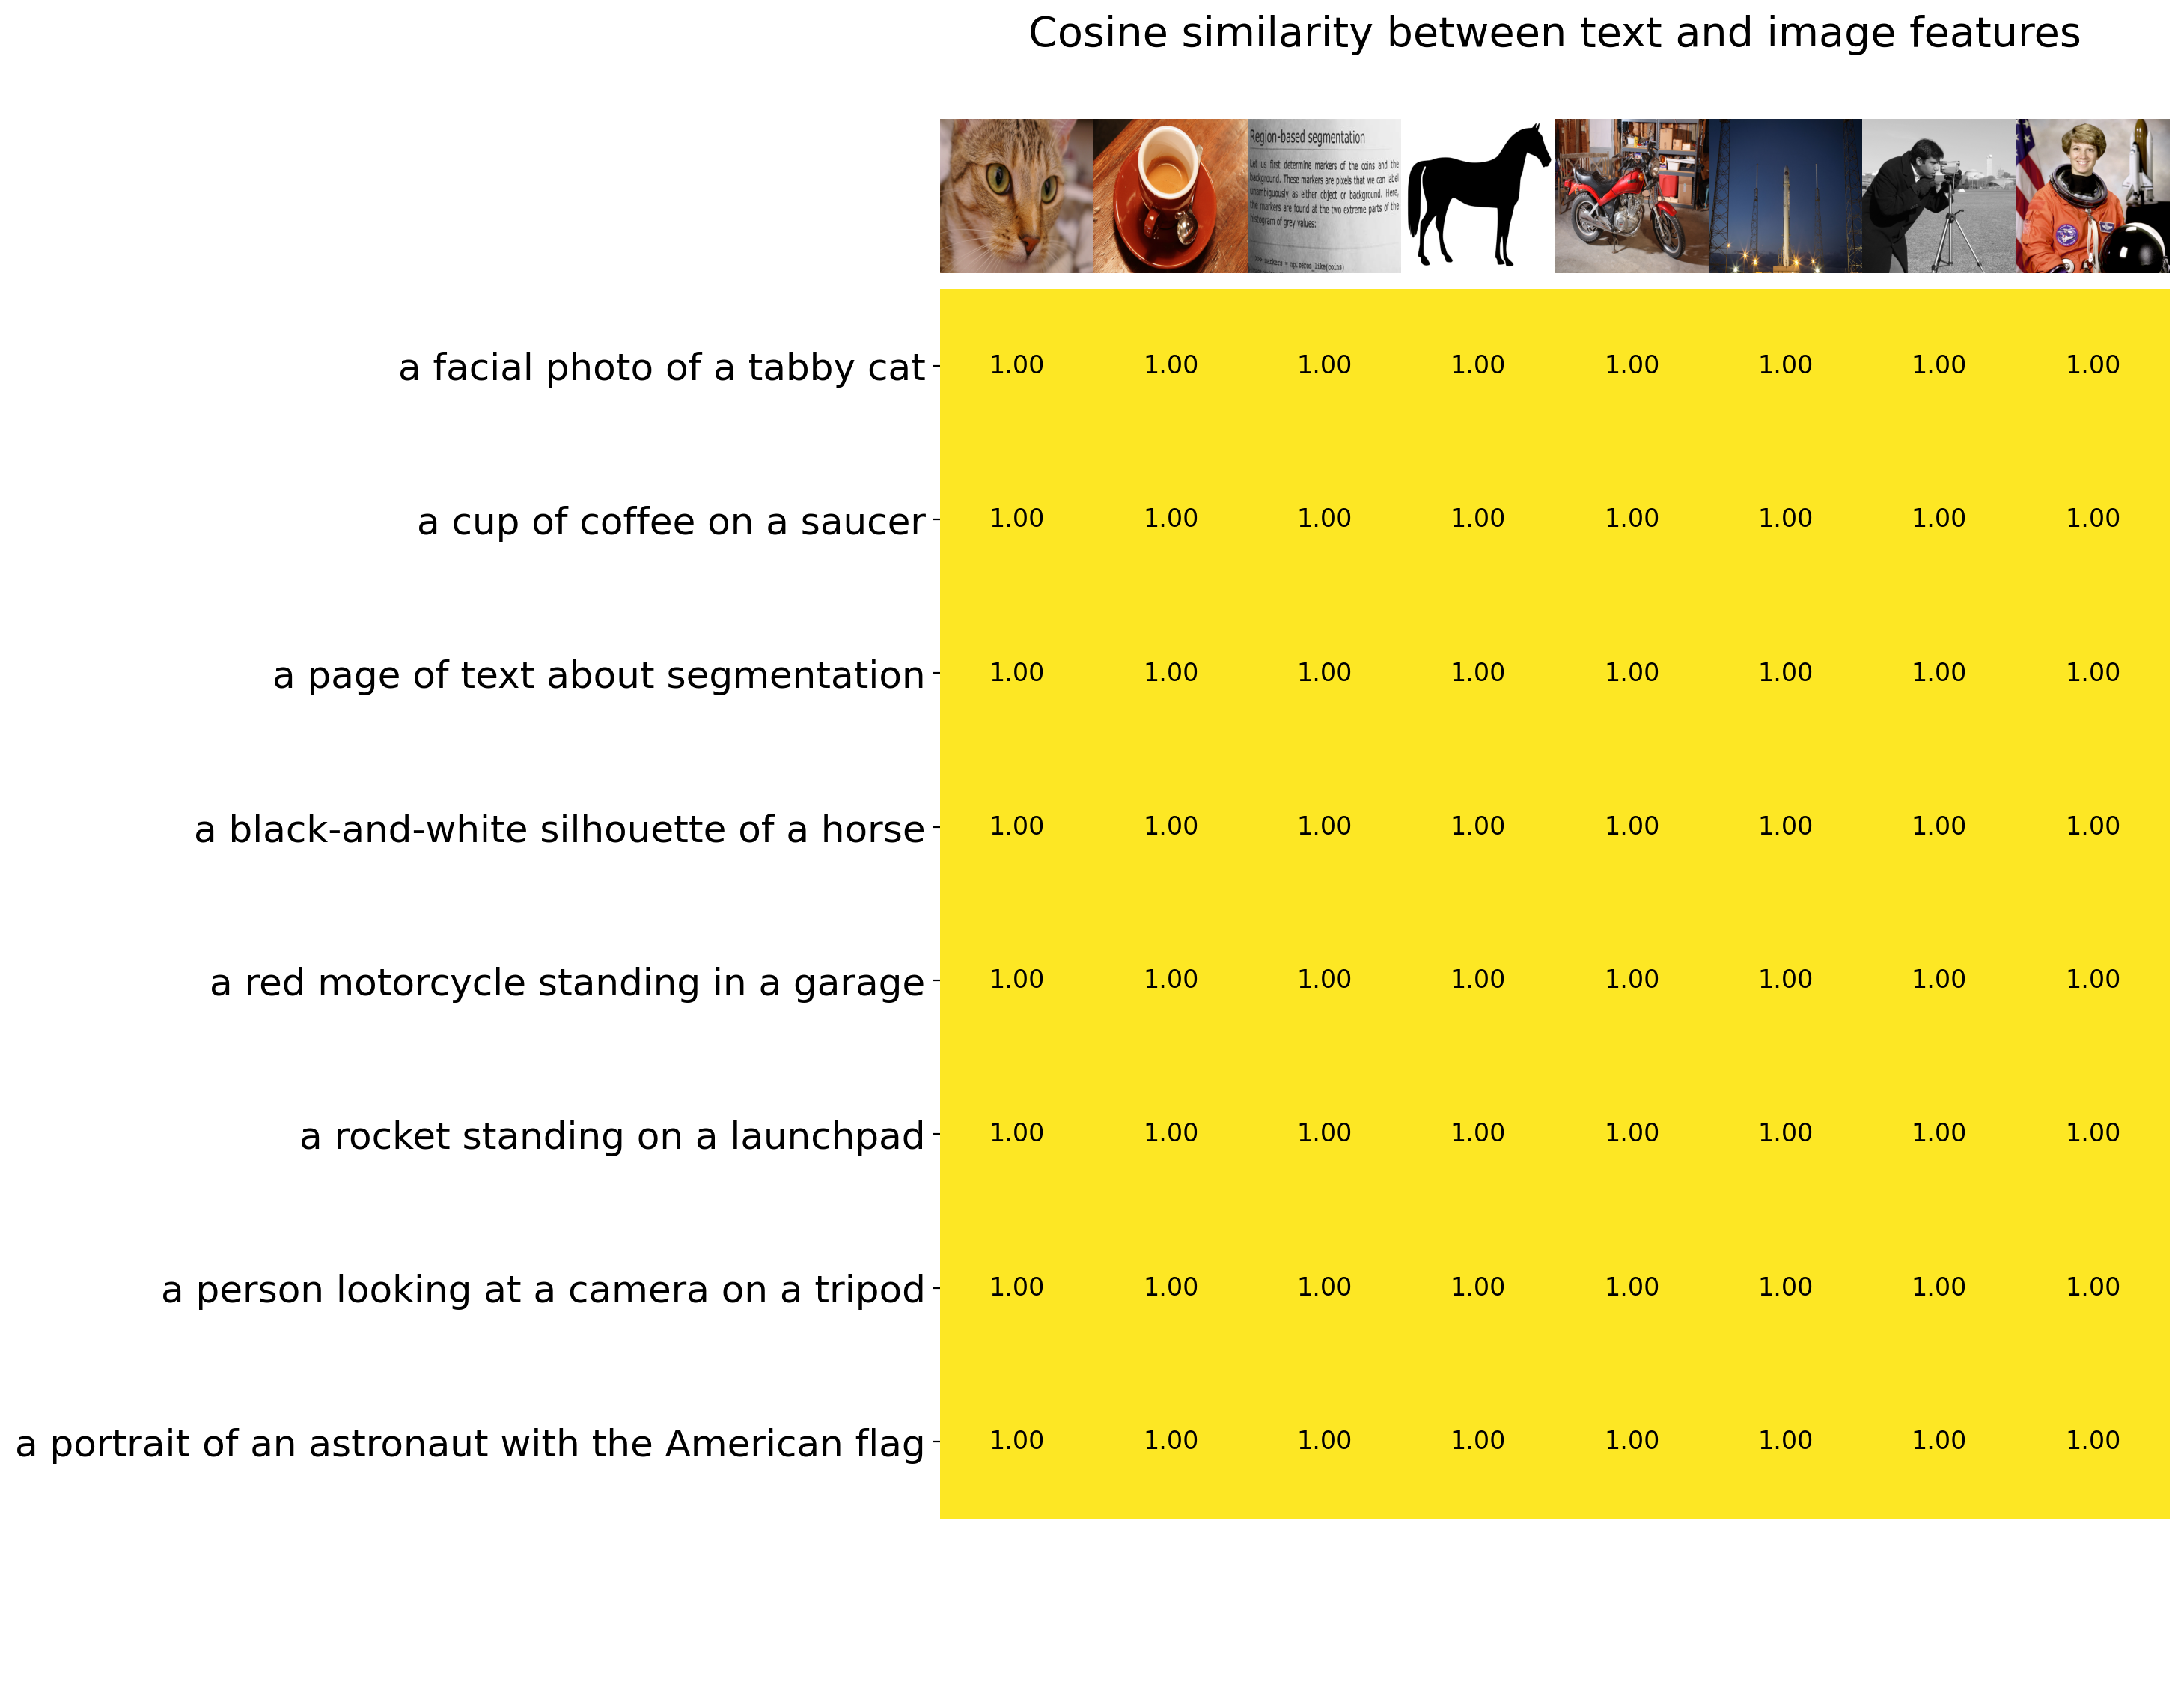

In [12]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [13]:
image = preprocess(Image.open("/home/tsuneda/CLIP/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.34   0.3196 0.34  ]]
